# Introduction

This notebook focuses on analyzing tweets related to vaccination by leveraging data analysis and Natural Language Processing (NLP) techniques. The goal is to extract meaningful insights about public sentiment regarding vaccinations, identify trends, and compare the effectiveness of different machine learning models for sentiment classification.

# Libraries and Dependencies

In [6]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Dataset Overview

In [7]:
df = pd.read_csv('/content/vaccination_tweets.csv')
df.head(4)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8082 non-null   int64 
 1   user_name         8082 non-null   object
 2   user_location     6452 non-null   object
 3   user_description  7575 non-null   object
 4   user_created      8082 non-null   object
 5   user_followers    8082 non-null   int64 
 6   user_friends      8082 non-null   int64 
 7   user_favourites   8082 non-null   int64 
 8   user_verified     8082 non-null   bool  
 9   date              8082 non-null   object
 10  text              8082 non-null   object
 11  hashtags          6133 non-null   object
 12  source            8081 non-null   object
 13  retweets          8082 non-null   int64 
 14  favorites         8082 non-null   int64 
 15  is_retweet        8082 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 899.9+ KB


In [9]:
df.isnull().sum()

,0
id,0
user_name,0
user_location,1630
user_description,507
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0


# Data Preprocessing

In [10]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [11]:
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [12]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8082 non-null   object
dtypes: object(1)
memory usage: 63.3+ KB


In [13]:
# define the data processing function
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [14]:
text_df['text'] = text_df['text'].apply(data_processing)
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [15]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the lemmatization function
def lemmatization(data):
    words = word_tokenize(data)
    text = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(text)

In [16]:
text_df['text'] = text_df['text'].apply(lemmatization)
text_df.head()

,text
0,folk said daikon paste could treat cytokine st...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,fact immutable senator even youre ethically st...
4,explain need vaccine borisjohnson matthancock ...


# Sentiment Analysis

In [17]:
# define the polarity function
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
text_df['polarity'] = text_df['text'].apply(polarity)
text_df.head(10)

,text,polarity
0,folk said daikon paste could treat cytokine st...,0.000
1,world wrong side history year hopefully bigges...,-0.500
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000
3,fact immutable senator even youre ethically st...,0.100
4,explain need vaccine borisjohnson matthancock ...,0.000
5,anyone useful adviceguidance whether covid vac...,0.400
6,bit sad claim fame success vaccination patriot...,-0.100
7,many bright day 2020 best 1 bidenharris winnin...,0.675
8,covid vaccine getting covidvaccine covid19 pfi...,0.000
9,covidvaccine state start getting covid19vaccin...,0.000


In [19]:
# define the sentiment function
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [20]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)
text_df.head()

,text,polarity,sentiment
0,folk said daikon paste could treat cytokine st...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,fact immutable senator even youre ethically st...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


# Data Visualization

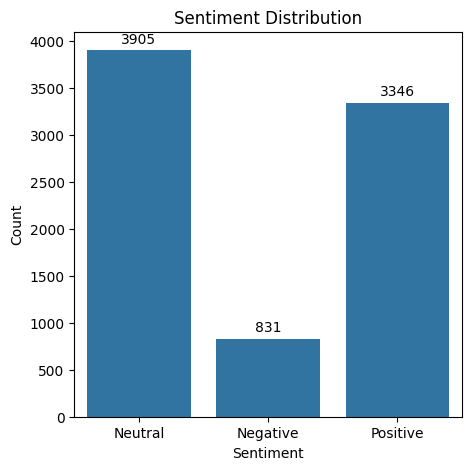

In [21]:
# Sentiment Distribution
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='sentiment', data = text_df)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

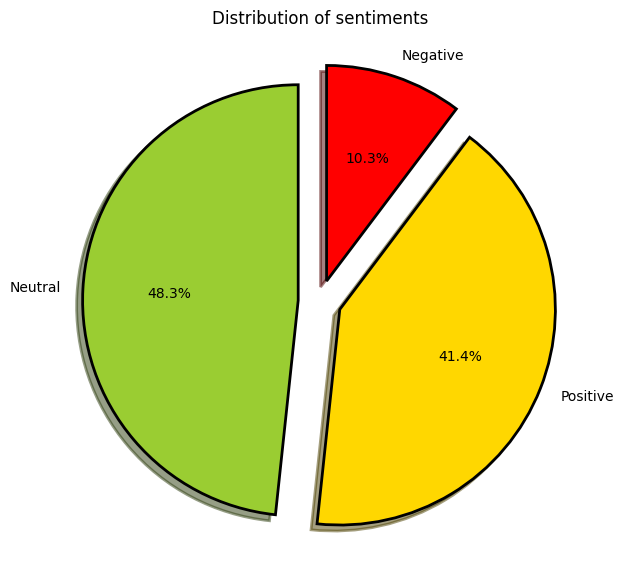

In [22]:
# Sentiment Distribution
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [23]:
# positive tweets
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets.head()

,text,polarity,sentiment
3,fact immutable senator even youre ethically st...,0.100,Positive
5,anyone useful adviceguidance whether covid vac...,0.400,Positive
7,many bright day 2020 best 1 bidenharris winnin...,0.675,Positive
10,death closing 300000 mark million people wait ...,0.250,Positive
11,cnnbrk covid19 covidvaccine vaccine corona pfi...,1.000,Positive


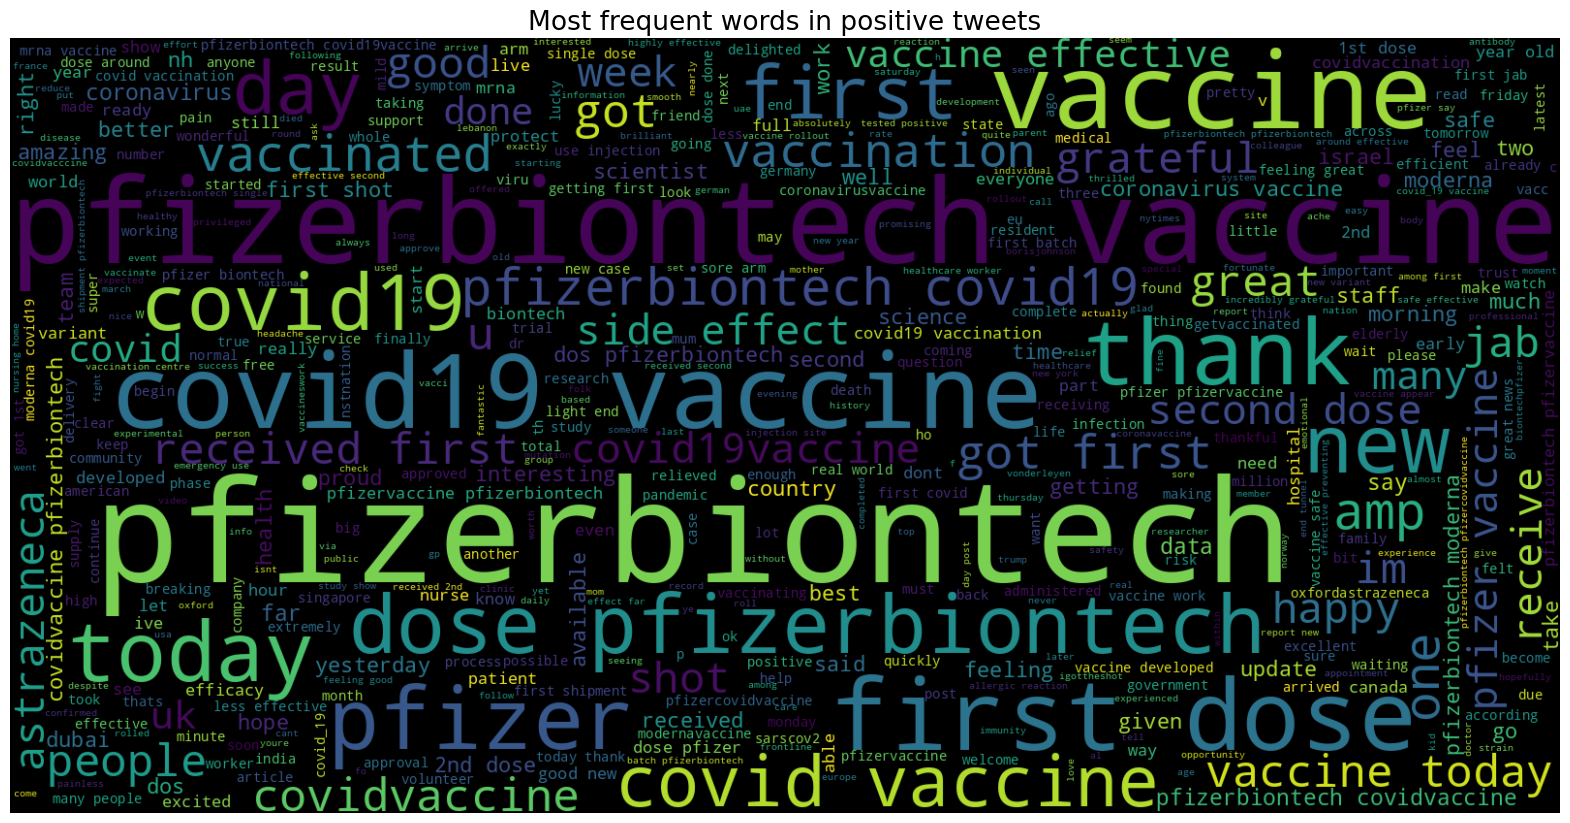

In [24]:
# Generate WordCloud for positive tweets
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [25]:
# negative tweets
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets.head()

,text,polarity,sentiment
1,world wrong side history year hopefully bigges...,-0.50,Negative
6,bit sad claim fame success vaccination patriot...,-0.10,Negative
18,pfizer rake billion expensive covidvaccine alb...,-0.50,Negative
19,trump administration failed deliver vaccine pr...,-0.50,Negative
26,wear mask wash hand remain socially distant po...,-0.05,Negative


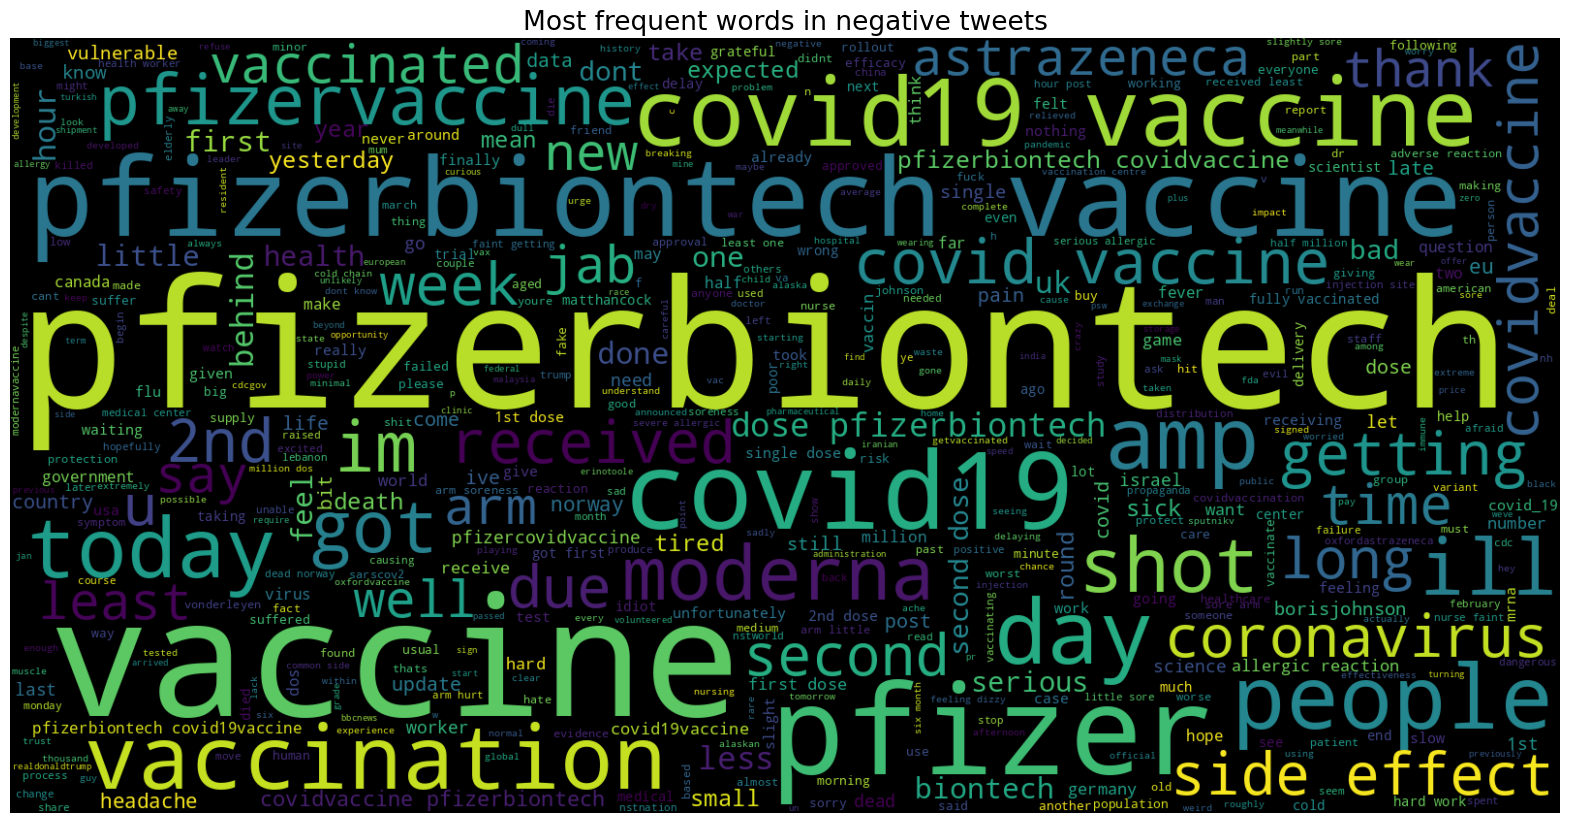

In [26]:
# Generate WordCloud for negative tweets
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [27]:
# neutral tweets
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets.head()

,text,polarity,sentiment
0,folk said daikon paste could treat cytokine st...,0.0,Neutral
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral
8,covid vaccine getting covidvaccine covid19 pfi...,0.0,Neutral
9,covidvaccine state start getting covid19vaccin...,0.0,Neutral


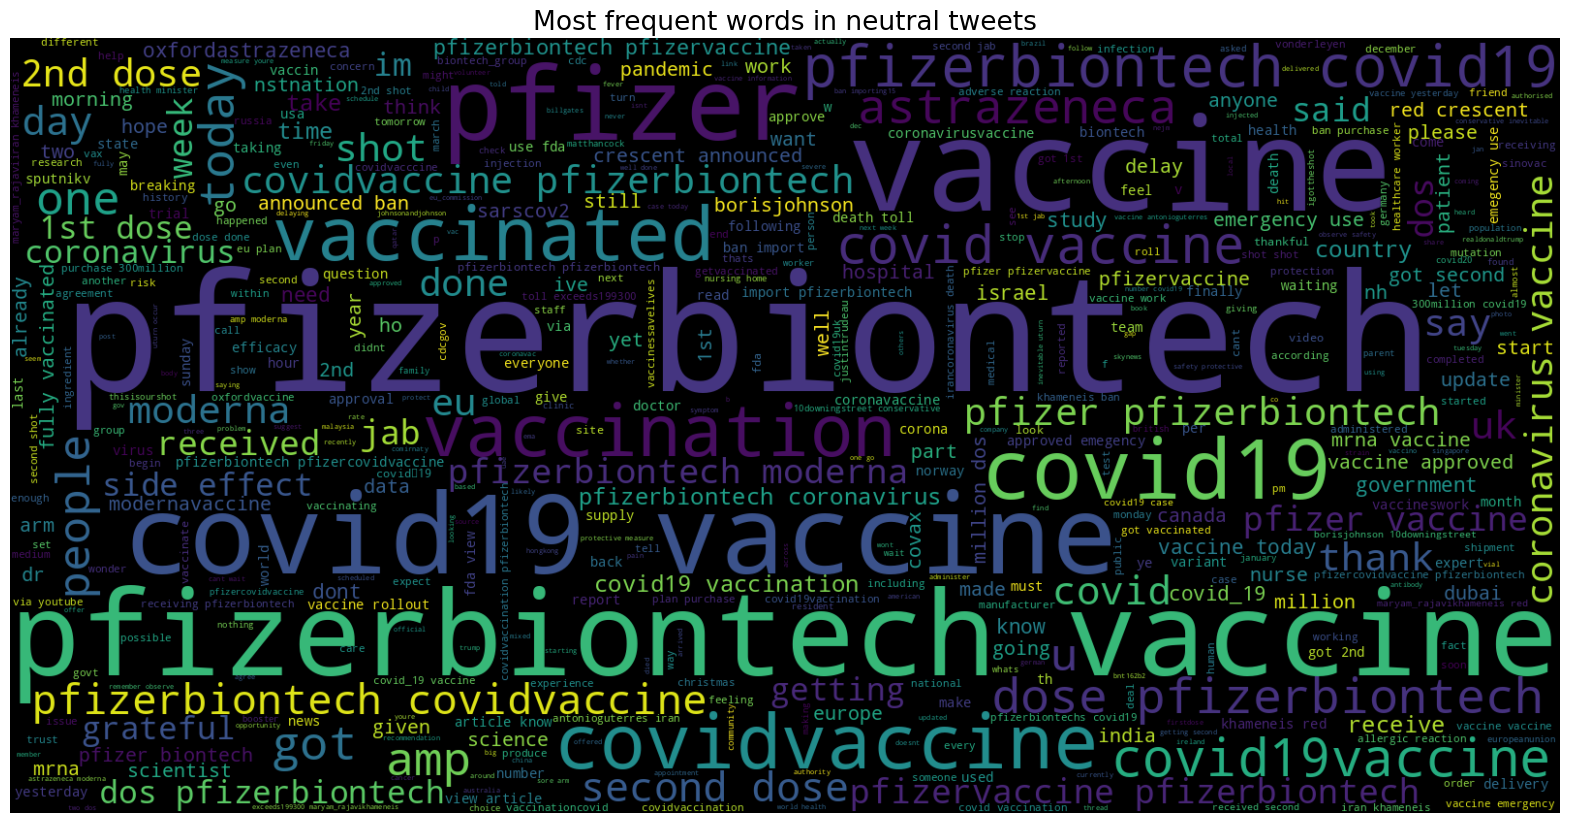

In [28]:
# Generate WordCloud for neutral tweets
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

# Feature Extraction

## Count Vectorizer

In [37]:
# Initialize CountVectorizer
cv = CountVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the text data
x = cv.fit_transform(text_df['text']).toarray()

# Define the target variable
y = text_df['sentiment']

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)

print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (6465, 5000)
Size of y_train: (6465,)
Size of x_test: (1617, 5000)
Size of y_test: (1617,)


# Model Building

In [30]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Linear SVC": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Dictionary to store accuracies
accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(x_train, y_train)  # Train the model
    predictions = model.predict(x_test)  # Make predictions

    # Calculate accuracy
    accuracy = accuracy_score(predictions, y_test)
    accuracies[model_name] = accuracy * 100

    # Print performance metrics
    print(f"\n{model_name} Test Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    print("-" * 50)



Training Logistic Regression...

Logistic Regression Test Accuracy: 87.01%
Confusion Matrix:
[[ 65  71  36]
 [  5 779  19]
 [  6  73 563]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.38      0.52       172
     Neutral       0.84      0.97      0.90       803
    Positive       0.91      0.88      0.89       642

    accuracy                           0.87      1617
   macro avg       0.87      0.74      0.77      1617
weighted avg       0.87      0.87      0.86      1617

--------------------------------------------------
Training Support Vector Machine...

Support Vector Machine Test Accuracy: 81.08%
Confusion Matrix:
[[ 20 120  32]
 [  1 793   9]
 [  1 143 498]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.12      0.21       172
     Neutral       0.75      0.99      0.85       803
    Positive       0.92      0.78      0.84       642

    accuracy      

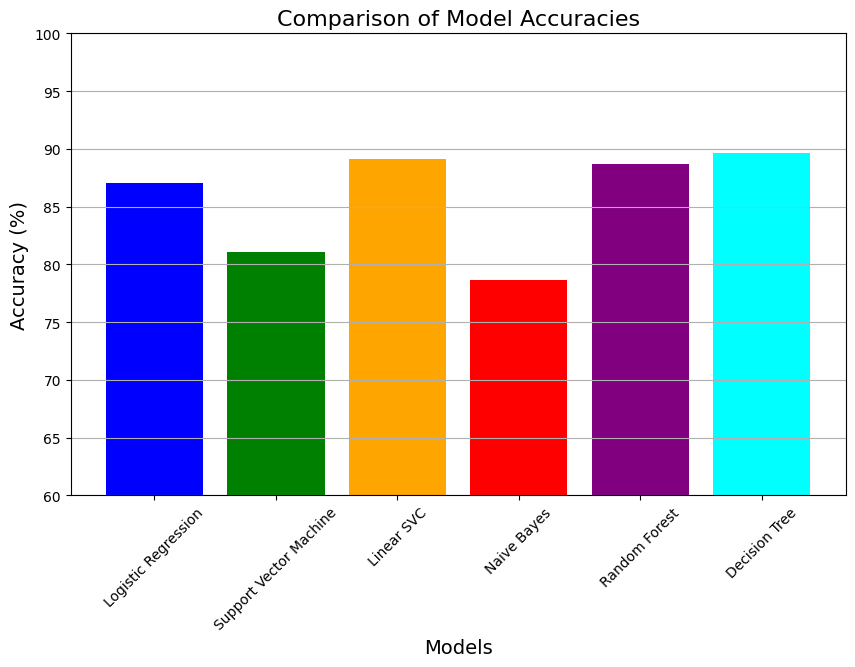

In [31]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
plt.title("Comparison of Model Accuracies", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(60, 100)
plt.grid(axis='y')
plt.show()

## TfidfVectorizer

In [32]:
# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the text data
x = tfidf.fit_transform(text_df['text']).toarray()

# Define the target variable
y = text_df['sentiment']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)

print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))


Size of x_train: (6465, 5000)
Size of y_train: (6465,)
Size of x_test: (1617, 5000)
Size of y_test: (1617,)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Linear SVC": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Dictionary to store accuracies
accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(x_train, y_train)  # Train the model
    predictions = model.predict(x_test)  # Make predictions

    # Calculate accuracy
    accuracy = accuracy_score(predictions, y_test)
    accuracies[model_name] = accuracy * 100

    # Print performance metrics
    print(f"\n{model_name} Test Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    print("-" * 50)



Training Logistic Regression...

Logistic Regression Test Accuracy: 82.93%
Confusion Matrix:
[[ 24 106  42]
 [  1 786  16]
 [  2 109 531]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.14      0.24       172
     Neutral       0.79      0.98      0.87       803
    Positive       0.90      0.83      0.86       642

    accuracy                           0.83      1617
   macro avg       0.86      0.65      0.66      1617
weighted avg       0.84      0.83      0.80      1617

--------------------------------------------------
Training Support Vector Machine...

Support Vector Machine Test Accuracy: 81.76%
Confusion Matrix:
[[ 21 116  35]
 [  1 790  12]
 [  3 128 511]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.12      0.21       172
     Neutral       0.76      0.98      0.86       803
    Positive       0.92      0.80      0.85       642

    accuracy      

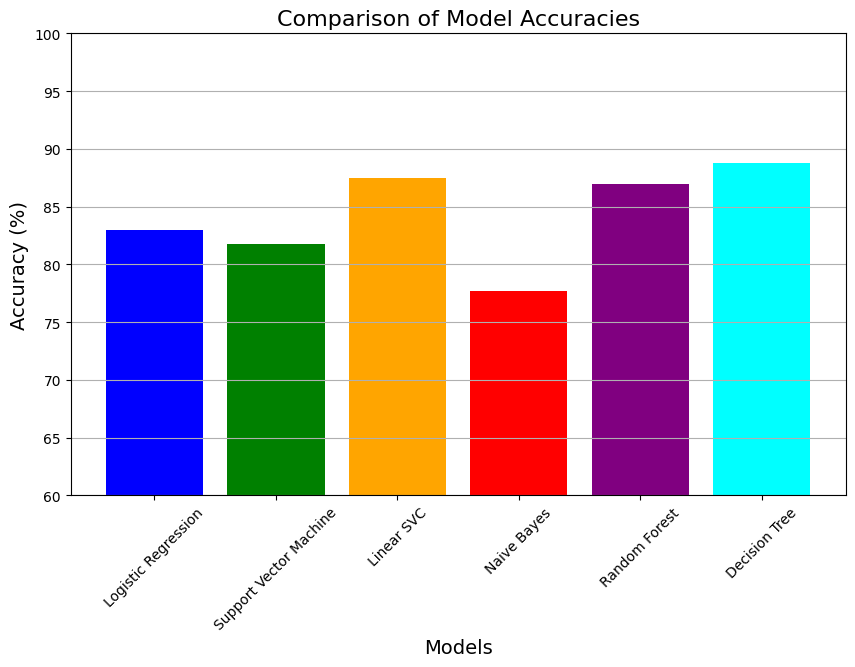

In [36]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
plt.title("Comparison of Model Accuracies", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(60, 100)
plt.grid(axis='y')
plt.show()

## Conclusion

Using both CountVectorization and TF-IDF Vectorization, the Decision Tree Classifier emerged as the best-performing model in our analysis. Through comprehensive evaluation, it consistently demonstrated the highest accuracy and robust performance across multiple configurations.

This result underscores the model's ability to effectively capture the underlying patterns in the text data, leveraging its flexibility and interpretability to classify sentiments with precision. The strong performance of the Decision Tree Classifier highlights its suitability for text-based sentiment analysis tasks, particularly when combined with optimized vectorization techniques.